In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core import missing

In [7]:
sns.set(style="whitegrid")

# Load dataset
df_benin = pd.read_csv("../data/benin-malanville.csv")
print("Shape:", df_benin.shape)
print("\nColumns:\n", df_benin.columns.tolist())

# Check the first few rows
df_benin.head(5)

Shape: (525600, 19)

Columns:
 ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [8]:
# 1. Summary Statistics
print("--- Summary Statistics (df.describe) ---")
print(df_benin.describe())

# 2. Missing-Value Report
print("\n--- Missing Value Report (df.isna().sum()) ---")
missing_values = df_benin.isna().sum()
print(missing_values)

# 3. List columns with >5% nulls
print("\n--- Columns with >5% Missing Values ---")
total_rows = len(df_benin)
missing_percentage = (missing_values / total_rows) * 100
print(missing_percentage[missing_percentage > 5])

--- Summary Statistics (df.describe) ---
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.00

In [9]:
# Create a copy to avoid changing the original data (good practice)
df_benin_clean = df_benin.copy()

# 1. Drop the 100% missing 'Comments' column
df_benin_clean = df_benin_clean.drop('Comments', axis=1)
print("Dropped 'Comments' column.")

# 2. Clean negative irradiance values (clip them at 0)
irradiance_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
for col in irradiance_cols:
    df_benin_clean[col] = df_benin_clean[col].clip(lower=0)

print("Clipped negative irradiance values to 0.")

# 3. Convert 'Timestamp' to datetime object
# This is crucial for time series analysis
df_benin_clean['Timestamp'] = pd.to_datetime(df_benin_clean['Timestamp'])
print("Converted 'Timestamp' column to datetime.")

# 4. Set 'Timestamp' as the index
# This makes plotting and analysis by time much easier
df_benin_clean = df_benin_clean.set_index('Timestamp')

# Let's check the 'min' values again to confirm our fix
print("\n--- New Summary Statistics (min values only) ---")
print(df_benin_clean[irradiance_cols].min())

Dropped 'Comments' column.
Clipped negative irradiance values to 0.
Converted 'Timestamp' column to datetime.

--- New Summary Statistics (min values only) ---
GHI     0.0
DNI     0.0
DHI     0.0
ModA    0.0
ModB    0.0
dtype: float64


In [10]:
# Calculate Z-scores
from scipy.stats import zscore

# Columns to check for outliers
zscore_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in zscore_cols:
    # Calculate z-score and add it as a new column
    df_benin_clean[f'{col}_zscore'] = np.abs(zscore(df_benin_clean[col]))

# Flag rows with Z > 3
# We create a new column 'is_outlier' that is True if *any* z-score is > 3
z_cols_to_check = [f'{col}_zscore' for col in zscore_cols]
df_benin_clean['is_outlier'] = df_benin_clean[z_cols_to_check].gt(3).any(axis=1)

# Report on our findings
outlier_count = df_benin_clean['is_outlier'].sum()
total_rows = len(df_benin_clean)

print(f"Total rows flagged as outliers (Z-score > 3): {outlier_count}")
print(f"Percentage of data flagged: {(outlier_count / total_rows) * 100:.2f}%")

# Show some of the outlier rows
print("\n--- Example Outlier Rows ---")
print(df_benin_clean[df_benin_clean['is_outlier']].head())

Total rows flagged as outliers (Z-score > 3): 7893
Percentage of data flagged: 1.50%

--- Example Outlier Rows ---
                        GHI    DNI    DHI    ModA    ModB  Tamb    RH   WS  \
Timestamp                                                                    
2021-08-09 11:11:00   836.0  235.0  610.6   778.8   783.8  30.3  68.2  3.2   
2021-08-09 11:12:00  1274.0  698.8  615.2  1210.3  1210.3  30.1  69.6  3.4   
2021-08-09 11:13:00   938.0  340.1  612.8   891.1   891.1  30.4  68.4  3.4   
2021-08-09 11:14:00   718.5  126.8  593.2   682.6   682.6  30.6  68.2  4.7   
2021-08-09 11:15:00  1349.0  771.8  618.0  1281.5  1281.5  30.9  67.1  4.0   

                     WSgust  WSstdev  ...  TModA  TModB  GHI_zscore  \
Timestamp                             ...                             
2021-08-09 11:11:00     4.1      0.7  ...   63.0   52.7    1.799571   
2021-08-09 11:12:00     4.1      0.6  ...   63.7   53.1    3.126436   
2021-08-09 11:13:00     4.6      0.9  ...   65.8   54.

In [12]:
# Select the original columns to save.
# We must drop 'Comments' (100% null) AND 'Timestamp' (which is now the index)
columns_to_save = df_benin.columns.drop(['Comments', 'Timestamp'])

# Now, we select only these columns from our cleaned dataframe.
# This correctly excludes all the new '_zscore' and 'is_outlier' columns.
df_to_save = df_benin_clean[columns_to_save]

# Save the cleaned DataFrame to a new CSV file.
# By default, .to_csv() *includes the index* in the file.
# Since our index is the 'Timestamp', this is perfect.
output_path = '../data/benin_clean.csv'
df_to_save.to_csv(output_path)

print(f"Successfully saved cleaned data to: {output_path}")
print("This file is in .gitignore, so it will NOT be committed to GitHub.")

Successfully saved cleaned data to: ../data/benin_clean.csv
This file is in .gitignore, so it will NOT be committed to GitHub.


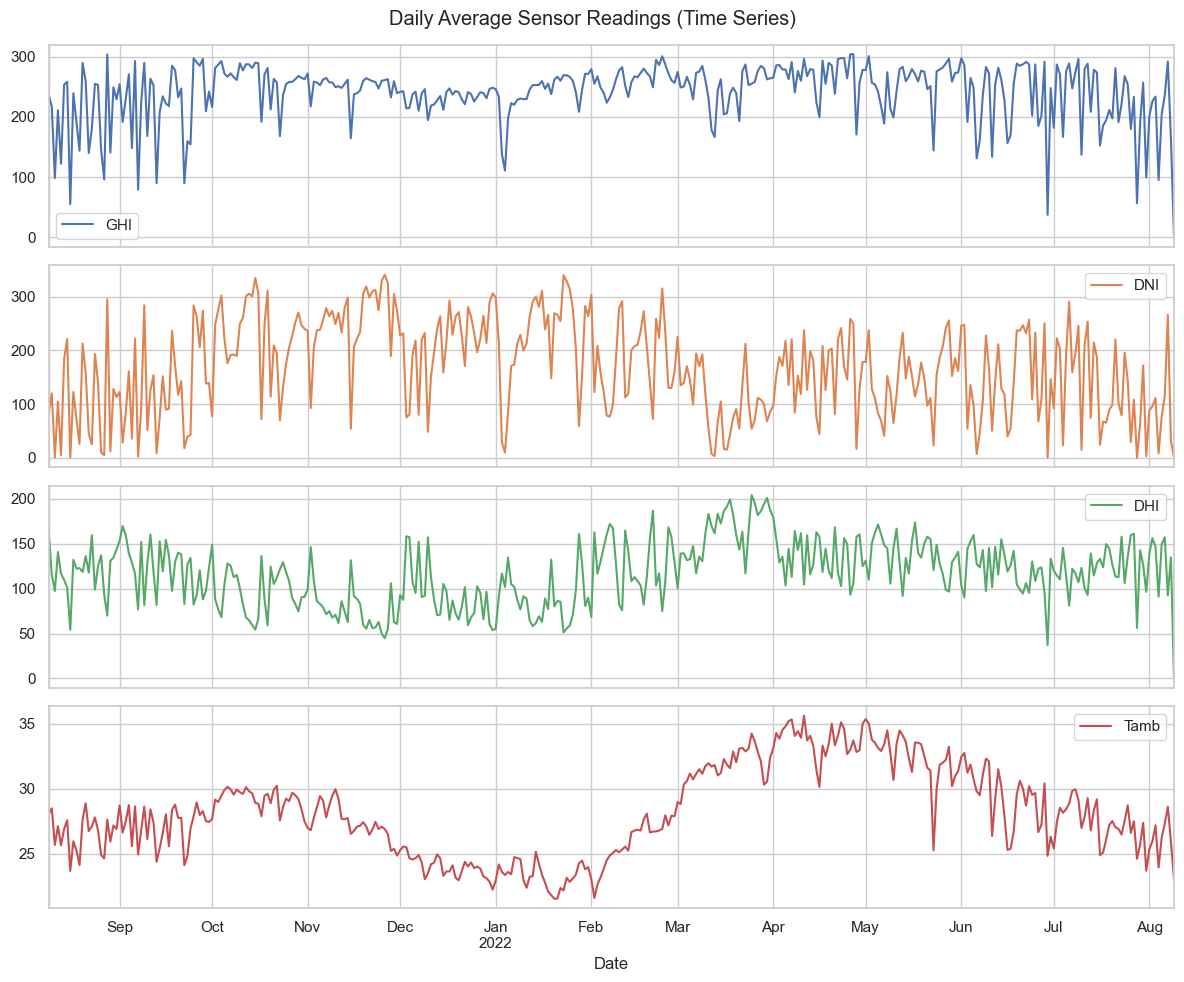

In [13]:
# Resample the data by Day ('D') and calculate the mean
# This makes the time series plots much cleaner
df_daily_mean = df_benin_clean.resample('D').mean()

# Columns to plot
plot_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

# Create the plots
# 'subplots=True' gives each variable its own plot
df_daily_mean[plot_cols].plot(
    subplots=True,
    figsize=(12, 10),
    title='Daily Average Sensor Readings (Time Series)',
    legend=True
)

plt.xlabel('Date')
plt.tight_layout() # Adjusts plot to prevent ovelapping
plt.show() # Display the plot

--- Average Sensor Reading by Cleaning Status ---
                ModA        ModB
Cleaning                        
0         236.524253  228.816071
1         307.229278  301.972165


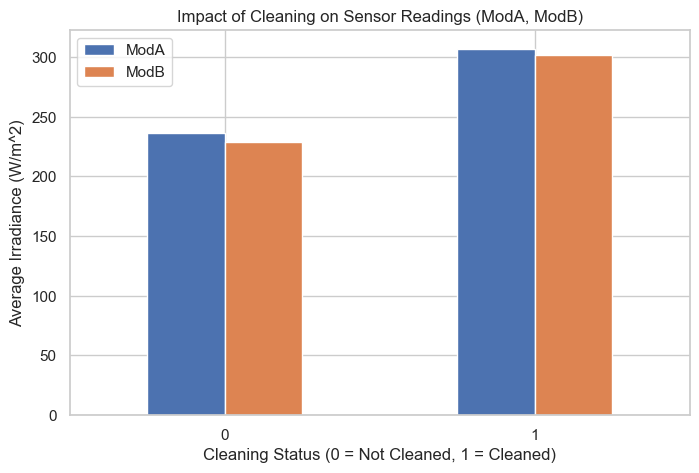

In [14]:
# Group the data by the 'Cleaning' flag (0 or 1)
# and calculate the average of ModA and ModB
cleaning_impact = df_benin_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

print("--- Average Sensor Reading by Cleaning Status ---")
print(cleaning_impact)

# Plot the results as a bar chart
cleaning_impact.plot(
    kind='bar',
    title='Impact of Cleaning on Sensor Readings (ModA, ModB)',
    figsize=(8, 5)
)

plt.ylabel('Average Irradiance (W/m^2)')
plt.xlabel('Cleaning Status (0 = Not Cleaned, 1 = Cleaned)')
plt.xticks(rotation=0) # Keep the x-axis labels (0, 1) horizontal
plt.show()

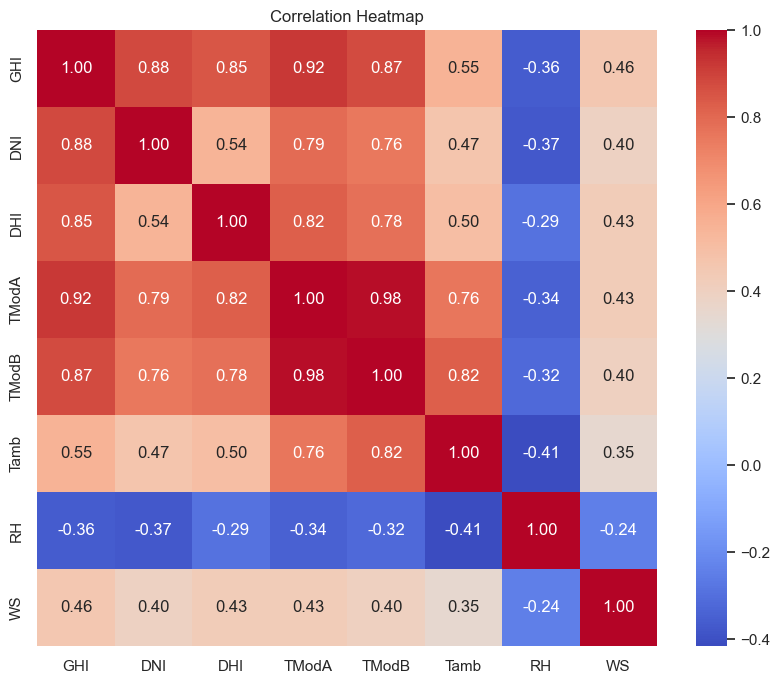

In [15]:
# Select columns for the correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS']
corr_matrix = df_benin_clean[corr_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show the correlation numbers
    fmt='.2f',        # Format numbers to 2 decimal places
    cmap='coolwarm'   # Use a blue-to-red color map
)
plt.title('Correlation Heatmap')
plt.show()

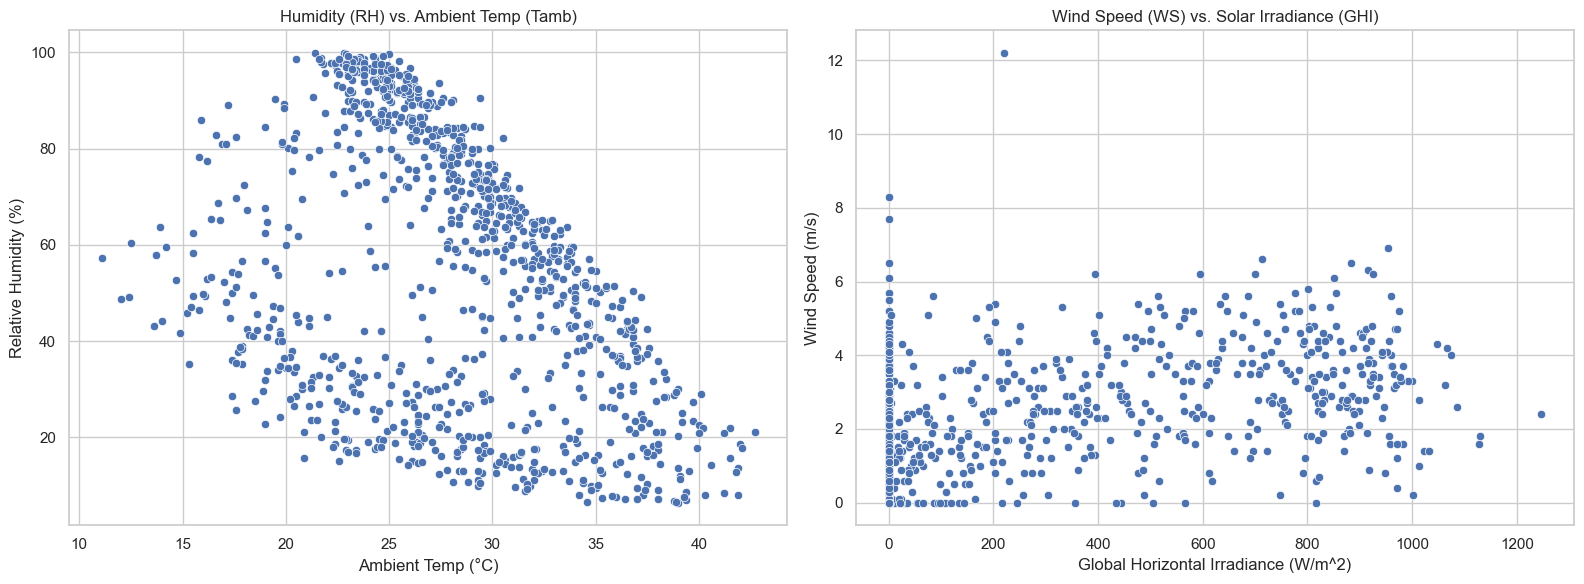

In [16]:
# Create a small sample of the data for cleaner scatter plots
df_sample = df_benin_clean.sample(n=1000, random_state=42)

# Create two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: RH vs. Tamb
sns.scatterplot(
    data=df_sample,
    x='Tamb',
    y='RH',
    ax=ax1
)
ax1.set_title('Humidity (RH) vs. Ambient Temp (Tamb)')
ax1.set_xlabel('Ambient Temp (°C)')
ax1.set_ylabel('Relative Humidity (%)')

# Plot 2: WS vs. GHI
sns.scatterplot(
    data=df_sample,
    x='GHI',
    y='WS',
    ax=ax2
)
ax2.set_title('Wind Speed (WS) vs. Solar Irradiance (GHI)')
ax2.set_xlabel('Global Horizontal Irradiance (W/m^2)')
ax2.set_ylabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

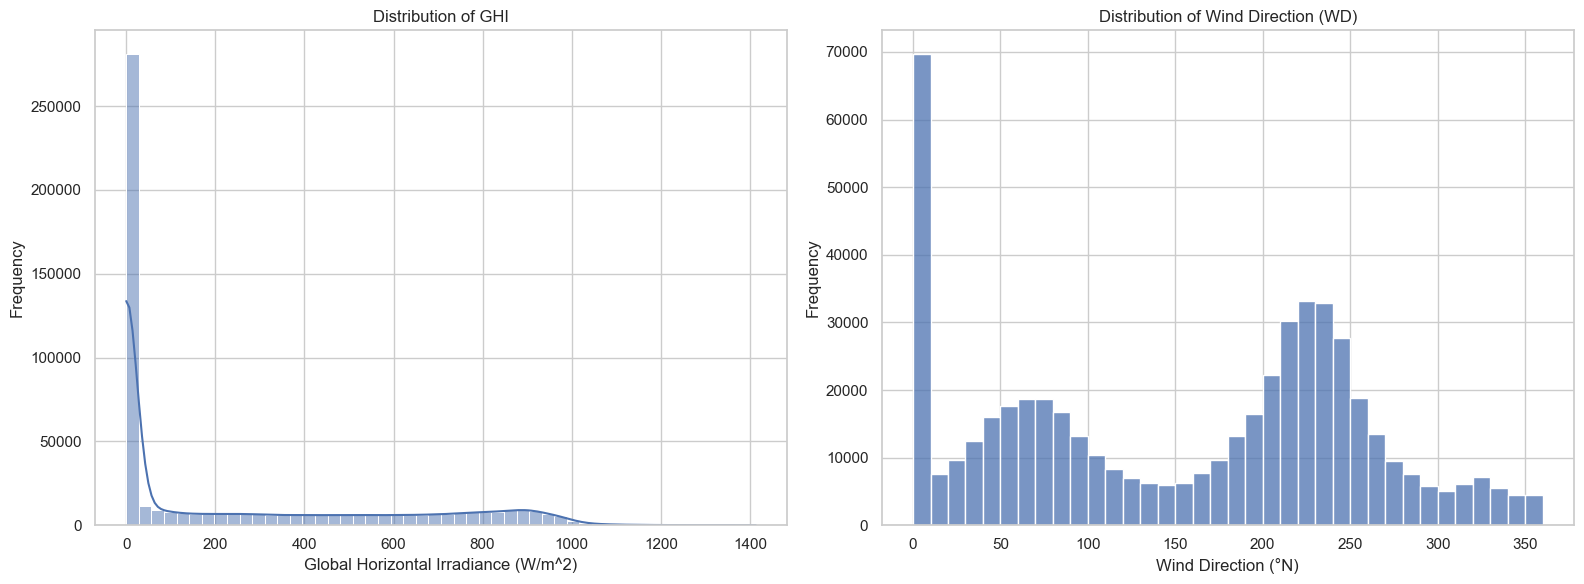

In [17]:
# Create two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: GHI Histogram
sns.histplot(
    data=df_benin_clean,
    x='GHI',
    bins=50,  # Divide the data into 50 bars
    kde=True, # Add a smooth line (Kernel Density Estimate)
    ax=ax1
)
ax1.set_title('Distribution of GHI')
ax1.set_xlabel('Global Horizontal Irradiance (W/m^2)')
ax1.set_ylabel('Frequency')

# Plot 2: Wind Direction Histogram
sns.histplot(
    data=df_benin_clean,
    x='WD',
    bins=36,  # 36 bins for 10-degree increments (0-360)
    kde=False,
    ax=ax2
)
ax2.set_title('Distribution of Wind Direction (WD)')
ax2.set_xlabel('Wind Direction (°N)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
import plotly.express as px

# We need to bin the Wind Direction (WD) into categories (N, NE, E, etc.)
# and also bin the Wind Speed (WS)
df_benin_clean['WD_binned'] = pd.cut(
    df_benin_clean['WD'],
    bins=16, # 16 bins for 16 directions
    labels=['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
            'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
)

# Bin Wind Speed
df_benin_clean['WS_binned'] = pd.cut(
    df_benin_clean['WS'],
    bins=[0, 2, 4, 6, 8, 10, 100], # Bins for wind speed m/s
    labels=['0-2', '2-4', '4-6', '6-8', '8-10', '>10']
)

# Create the Wind Rose chart
# We need to count the occurrences of each combination
wind_rose_data = df_benin_clean.groupby(['WD_binned', 'WS_binned']).size().reset_index(name='count')

fig = px.bar_polar(
    wind_rose_data,
    r="count",
    theta="WD_binned",
    color="WS_binned",
    title="Wind Rose for Benin",
    template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Plasma_r
)

# Display the plot
fig.show()

/var/folders/vp/jp6dyn2x6v7dvrtdk8mn938r0000gn/T/ipykernel_17451/2152778516.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_rose_data = df_benin_clean.groupby(['WD_binned', 'WS_binned']).size().reset_index(name='count')


In [19]:
# We'll use the same 1000-point sample as before
fig = px.scatter(
    df_sample,
    x="GHI",
    y="Tamb",
    size="RH",       # Bubble size
    color="RH",      # Bubble color
    title="GHI vs. Ambient Temp (Bubble size = Relative Humidity)",
    template="plotly_dark",
    size_max=15      # Keep bubbles from getting too big
)

fig.update_layout(
    xaxis_title="Global Horizontal Irradiance (W/m^2)",
    yaxis_title="Ambient Temp (°C)"
)

fig.show()